<a href="https://colab.research.google.com/github/jayeshraj619/AI-LAB/blob/master/SPI1%20VS%20H%20%26%20W.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns


In [ ]:
#from datetime import datetime

#Read the csv file
df = pd.read_csv('/content/data.csv')
print(df.head()) #7 columns, including the Date. 

         Date      spi1  avgw vs spi1  avgh vs spi1
0  1979-05-01 -1.714817      1.982121      0.680302
1  1979-06-01 -0.889794      1.233030      0.749740
2  1979-07-01  0.889794      1.248285      0.856281
3  1979-08-01 -0.364798      1.316450      0.942733
4  1979-09-01  0.143235      1.741138      0.903878


In [ ]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.head(12))

0    1979-05-01
1    1979-06-01
2    1979-07-01
3    1979-08-01
4    1979-09-01
5    1979-10-01
6    1979-11-01
7    1979-12-01
8    1980-01-01
9    1980-02-01
10   1980-03-01
11   1980-04-01
Name: Date, dtype: datetime64[ns]


In [ ]:
#Variables for training
cols = list(df)[1:4]
print(cols)

['spi1', 'avgw vs spi1', 'avgh vs spi1']


In [ ]:
#New dataframe with only training data - 3 columns
df_for_training = df[cols].astype(float)

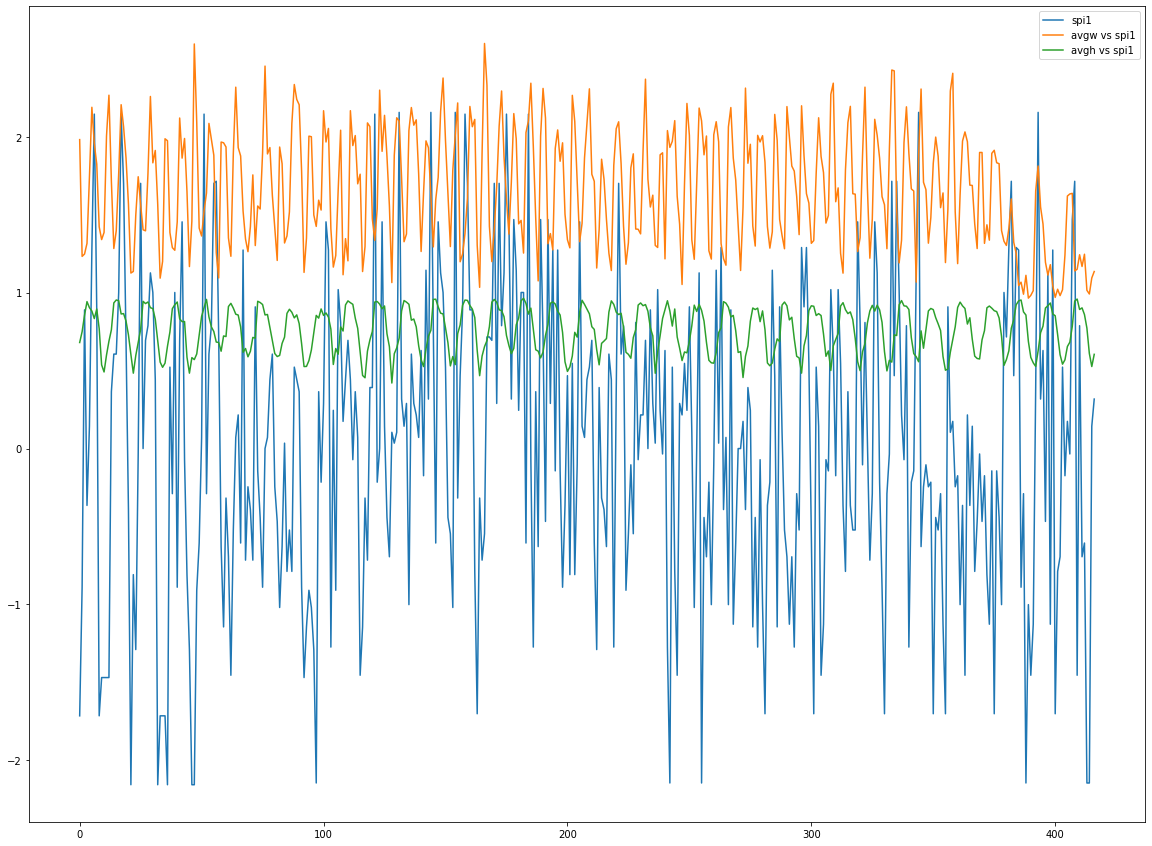

In [ ]:
df_for_plot=df_for_training.tail(500)
df_for_plot.plot.line()


In [ ]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [ ]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 12  # Number of past days we want to use to predict the future.


In [ ]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (405, 3)
#405 refers to the number of data points and 3 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (405, 12, 3).
trainY shape == (405, 1).


In [ ]:
#In my case, trainX has a shape (417, 14, 5). 
#417 because we are looking back 12 days (417 - 12 = 405). 
#Remember that we cannot look back 12 days until we get to the 13th day. 
#Also, trainY has a shape (405, 1). Our model only predicts a single value, but 
#it needs multiple variables (3 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 3 variables which we do not have. 
#We need to predict all variables if we want to do that.

In [ ]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 12, 64)            17408     
                                                                 
 lstm_15 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


Epoch 1/70
23/23 [==============================] - 0s 19ms/step - loss: 0.5052 - val_loss: 1.8697
Epoch 2/70
23/23 [==============================] - 0s 13ms/step - loss: 0.5215 - val_loss: 2.6901
Epoch 3/70
23/23 [==============================] - 0s 13ms/step - loss: 0.5203 - val_loss: 1.5554
Epoch 4/70
23/23 [==============================] - 0s 12ms/step - loss: 0.4952 - val_loss: 1.2240
Epoch 5/70
23/23 [==============================] - 0s 13ms/step - loss: 0.4828 - val_loss: 1.9398
Epoch 6/70
23/23 [==============================] - 0s 13ms/step - loss: 0.5175 - val_loss: 1.4886
Epoch 7/70
23/23 [==============================] - 0s 13ms/step - loss: 0.4805 - val_loss: 1.5014
Epoch 8/70
23/23 [==============================] - 0s 13ms/step - loss: 0.4871 - val_loss: 1.2500
Epoch 9/70
23/23 [==============================] - 0s 12ms/step - loss: 0.5053 - val_loss: 1.2492
Epoch 10/70
23/23 [==============================] - 0s 13ms/step - loss: 0.5027 - val_loss: 1.2526
Epoch 11/

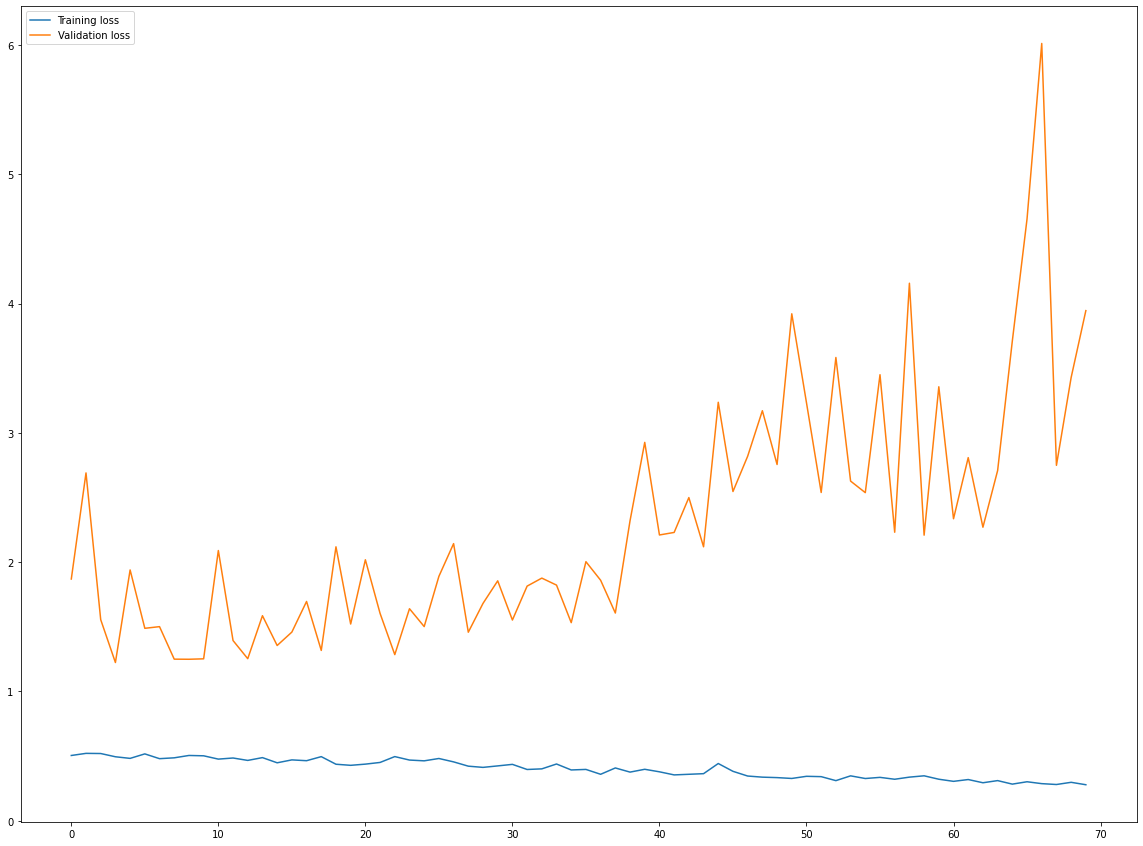

In [ ]:
# fit the model
history = model.fit(trainX, trainY, epochs=70, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 417
n_months_for_prediction=405  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_months_for_prediction, freq="M").tolist()
print(predict_period_dates)

[Timestamp('1979-05-31 00:00:00', freq='M'), Timestamp('1979-06-30 00:00:00', freq='M'), Timestamp('1979-07-31 00:00:00', freq='M'), Timestamp('1979-08-31 00:00:00', freq='M'), Timestamp('1979-09-30 00:00:00', freq='M'), Timestamp('1979-10-31 00:00:00', freq='M'), Timestamp('1979-11-30 00:00:00', freq='M'), Timestamp('1979-12-31 00:00:00', freq='M'), Timestamp('1980-01-31 00:00:00', freq='M'), Timestamp('1980-02-29 00:00:00', freq='M'), Timestamp('1980-03-31 00:00:00', freq='M'), Timestamp('1980-04-30 00:00:00', freq='M'), Timestamp('1980-05-31 00:00:00', freq='M'), Timestamp('1980-06-30 00:00:00', freq='M'), Timestamp('1980-07-31 00:00:00', freq='M'), Timestamp('1980-08-31 00:00:00', freq='M'), Timestamp('1980-09-30 00:00:00', freq='M'), Timestamp('1980-10-31 00:00:00', freq='M'), Timestamp('1980-11-30 00:00:00', freq='M'), Timestamp('1980-12-31 00:00:00', freq='M'), Timestamp('1981-01-31 00:00:00', freq='M'), Timestamp('1981-02-28 00:00:00', freq='M'), Timestamp('1981-03-31 00:00:00'

In [ ]:
#Make prediction
prediction = model.predict(trainX[-n_months_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
(y_pred_future) = scaler.inverse_transform(prediction_copies)[:,0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  F

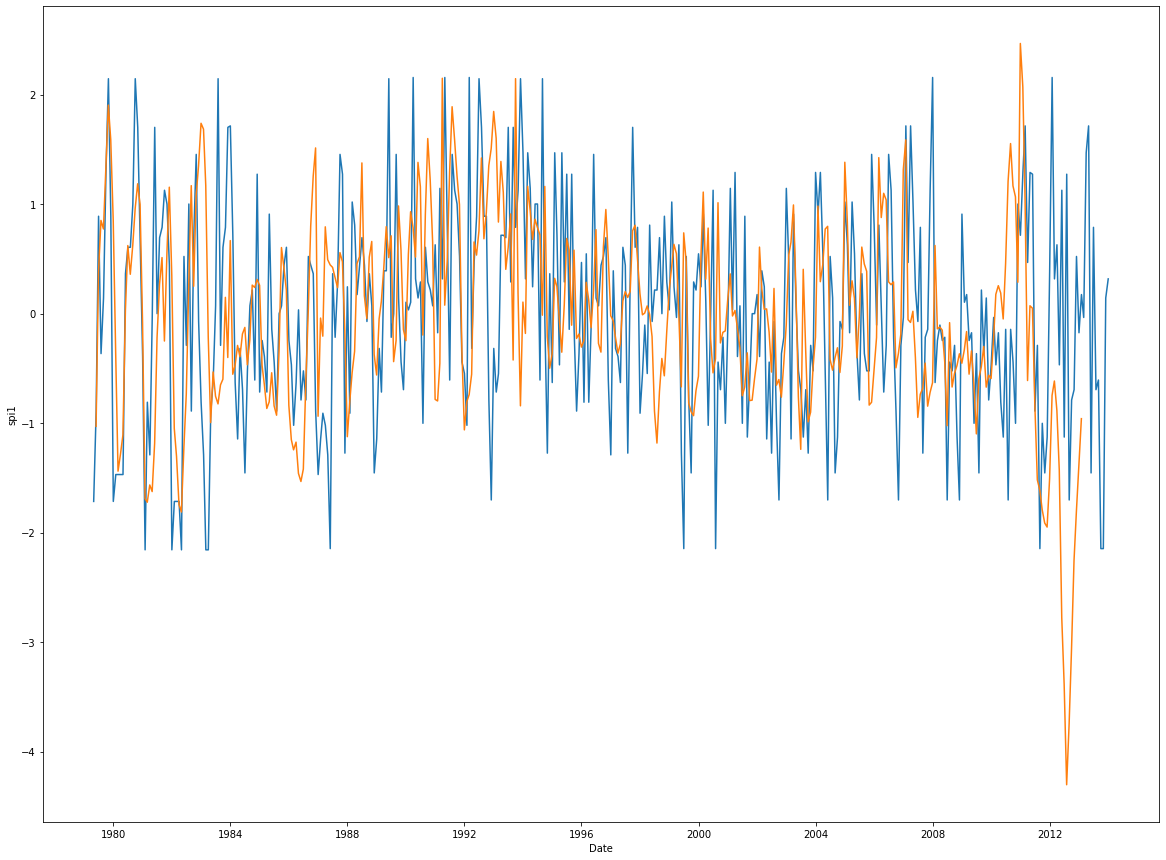

In [ ]:
#Convert timestamp to date
forecast_dates = []

for time_i in predict_period_dates:

    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'spi1']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '1979-05-1']
from matplotlib import rcParams
plt.rcParams["figure.figsize"]=20,15
sns.lineplot(original['Date'], original['spi1'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])